# Classifying drawn trajectories

In this dataset we have 2D drawn trajectories from 46 subjects. Each trajectory can be either a *circle*, a *diamond*, or a *square*. During the drawing of each shape, the subject is observing another shape appearing on the screen, that can be the *same* or *different* wrt the shape they are drawing.

Here we are using a small Deep Neural Network to detect which shape the subject is drawing, and whether they were pbserving the same or a different shape.

### Highlights:
- taking as input drawn trajectories (100 data points of xy positions)
- building up a **tensorflow** deep neural network
- using a Leave one out cross-validation approach
- testing the model performance on the test subject iteratively

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import os
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

### Loading the trajectories
The drawings have already been interpolated, each trajectory is 100 data points

In [64]:
# Defining input and output directories and loading behavioral data
os.chdir('C:/Users/silvia/seadrive_root/Silvia F/My Libraries/JointRSA2/JointDrawing_BIDS/')

pps_folders = os.listdir()
subjlist = [x for x in pps_folders if x.startswith('sub') ]

# dropping some Subjects because of exclusion criteria
subjlist.remove('sub-003')  # outlier for EEG
subjlist.remove('sub-015')  # outlier for behavior
subjlist.remove('sub-022')  # outlier for EEG
subjlist.remove('sub-029')  # outlier for behavior

# initializing variables
X_all = []
y_all = []
subject_all = []

for subj in subjlist:
    
    # loading and cleaning data
    data = pd.read_csv(subj + "/beh-processed/InterpolatedTrajectories.csv")
    data_keep = data.loc[np.all([data.catch == 0 , data.incomplete_traj == 0 , data.wrong_shape == 0 , data.gross_error == 0], axis = 0), :]
    
    # creating X and y
    X1 = np.empty([len(np.unique(data_keep.trial_sort)), np.max(data_keep.traj_point)+1, 2])
    y1 = np.zeros([len(np.unique(data_keep.trial_sort)), 4])

    # hot-encoding drawing features
    for idx, t in enumerate(np.unique(data_keep.trial_sort)):
        X1[idx, :, :] = data_keep.loc[data_keep.trial_sort == t, ['x', 'y']].to_numpy()
        y1[idx, 0] = 1 if data_keep[data_keep.trial_sort == t]['shape'].iloc[0] == 'c' else 0
        y1[idx, 1] = 1 if data_keep[data_keep.trial_sort == t]['shape'].iloc[0] == 'd' else 0
        y1[idx, 2] = 1 if data_keep[data_keep.trial_sort == t]['shape'].iloc[0] == 's' else 0 
        y1[idx, 3] = 1 if data_keep[data_keep.trial_sort == t]['cong'].iloc[0] == 'congruent' else 0
    
    # reshaping X to have all features in one dimension
    X1 = np.reshape(X1, [len(np.unique(data_keep.trial_sort)), -1])

    X_all.append(X1)
    y_all.append(y1)
    
    # keeping track of subjectID
    subject_all.append(np.repeat(subj, len(y1)))

### Plotting example trajectories

To better understand what we are dealing with, we will randomly pick 10 drawings and plot them.

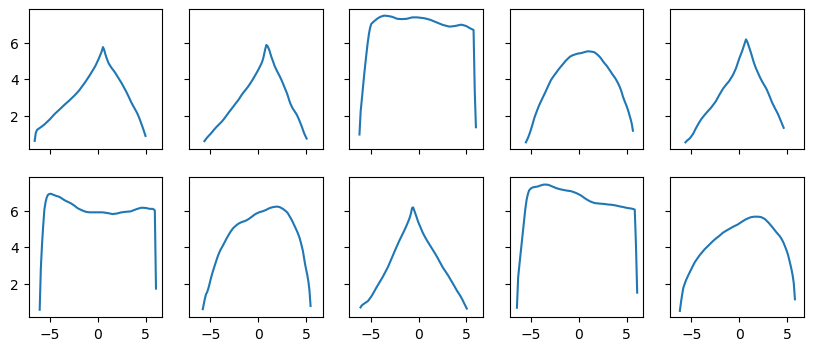

In [65]:
select = np.random.randint(len(X), size=10)
X_draw = X[:10, :]

f, axs = plt.subplots(2, 5, sharex = True, sharey = True, figsize = [10, 4])
for idx in range(len(select)):
    plt.subplot(2, 5, idx+1)
    toplot = X_draw[idx, :].reshape([100, 2])
    plt.plot(toplot[:, 0], toplot[:, 1])

### Checking X/y dimensions

X and y have the same lengths (i.e., number of trials). y has 4 columns, which represent the hot-encoded features of the current trial:
- column 0: is the drawing a circle? 0/1
- column 1: is the drawing a diamond? 0/1
- column 2: is the drawing a square? 0/1
- column 3: is the subject observing the same or a different shape? 0/1

In [66]:
X = np.concatenate(X_all, axis = 0)
y = np.concatenate(y_all, axis = 0)
subject = np.concatenate(subject_all, axis = 0)

print(f"Number of Subjects/CV folds: {len(np.unique(subject))}")
print(f"Dimensions of X: {X.shape}")
print(f"Dimensions of y: {y.shape}")
print(f"\n First 5 instances of y:\n{y[:5, :]}")

Number of Subjects/CV folds: 46
Dimensions of X: (11941, 200)
Dimensions of y: (11941, 4)

 First 5 instances of y:
[[0. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


### Building the Neural Network

We will use a model with **2 hidden layers** with a **reLu** activation function.
For the output layer, we will have *4 nodes* with a **sigmoid** activation function, which will provide probabilities akin to our y target variable.

In [73]:
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [  tf.keras.Input(shape=(200,)),
       Dense(25, activation = 'relu', name = 'L1'),
       Dense(15, activation = 'relu', name = 'L2'),
       Dense(4, activation = 'sigmoid', name = 'Output'),
    ], name = "SimpleShapeDiscrimination" 
)

model.summary()

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

Model: "SimpleShapeDiscrimination"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ L1 (Dense)                           │ (None, 25)                  │           5,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L2 (Dense)                           │ (None, 15)                  │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 4)                   │              64 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,479 (21.40 KB)

 Trainable params: 5,479 (21.40 KB)

 Non-trainable params: 0 (0.00 B)

### Model training and testing in a crossvalidated loop

We will train the model 46 times, every time we leave out one subject that we will use as the test set.
In each crossvalidation fold, we use a **StandardScaler** to normalize the input features of the training set, and we will apply the same scaler to the testing set.

In [139]:
%%capture

# initializing variable to store predictions of the model across cv folds
results_shape_train = np.zeros([len(subjlist), 2])
results_congruency_train = np.zeros([len(subjlist), 2])
results_shape_test = np.zeros([len(subjlist), 2])
results_congruency_test = np.zeros([len(subjlist), 2])

for i, (train_index, test_index) in enumerate(LeaveOneGroupOut().split(X, y, subject)):
    print(f"Fold {i} - Test Subject: {subject[test_index][0]}")


    x_train = X[train_index]
    y_train = y[train_index]

    x_test = X[test_index]
    y_test = y[test_index]

    # scaling training set
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)

    # training the model
    model.fit(x_train_scaled, y_train, epochs = 20)

    # retrieving accuracies on training set
    predictions_train = model.predict(x_train_scaled)

    predicted_shape = np.zeros(len(predictions_train))
    confidence_shape = np.zeros(len(predictions_train))
    predicted_congruence = np.zeros(len(predictions_train))
    confidence_congruence = np.zeros(len(predictions_train))
    
    for j, pred in enumerate(predictions_train):
        predicted_shape[j] = np.argmax(pred[:3])
        confidence_shape[j] = pred[np.argmax(pred[:3])]
        predicted_congruence[j] = 1 if pred[-1] > .5 else 0
        confidence_congruence[j] = pred[-1] if pred[-1] > 0.5 else (1 - pred[-1])
        
    correct_shape = np.zeros(len(y_train))
    for j, item in enumerate(y_train):
        correct_shape[j]= np.argmax(item[:3])

    check = correct_shape == predicted_shape
    
    # add results to final array
    results_shape_train[i, 0] = np.mean(check)
    results_shape_train[i, 1] = np.mean(confidence_shape)

    results_congruency_train[i, 0] = np.mean(predicted_congruence == y_train[:, -1])
    results_congruency_train[i, 1] = np.mean(confidence_congruence)

    # scaling testing set: note: we are using the scaling parameters of the training set
    x_test_scaled = scaler.transform(x_test)

    # predicted accuracies on the left out subject
    predictions_test = model.predict(x_test_scaled)

    predicted_shape = np.zeros(len(predictions_test))
    confidence_shape = np.zeros(len(predictions_test))
    predicted_congruence = np.zeros(len(predictions_test))
    confidence_congruence = np.zeros(len(predictions_test))
    
    for j, pred in enumerate(predictions_test):
        predicted_shape[j] = np.argmax(pred[:3])
        confidence_shape[j] = pred[np.argmax(pred[:3])]
        predicted_congruence[j] = 1 if pred[-1] > .5 else 0
        confidence_congruence[j] = pred[-1] if pred[-1] > 0.5 else (1 - pred[-1])
    
    correct_shape = np.zeros(len(y_test))
    for j, item in enumerate(y_test):
        correct_shape[j]= np.argmax(item[:3])

    check = correct_shape == predicted_shape
    
    # add results to final array
    results_shape_test[i, 0] = np.mean(check)
    results_shape_test[i, 1] = np.mean(confidence_shape)

    results_congruency_test[i, 0] = np.mean(predicted_congruence == y_test[:, -1])
    results_congruency_test[i, 1] = np.mean(confidence_congruence)

## Results
Reporting results for accuracy and confidence of the model averaged across cv folds

In [169]:
print(f"Training Set\n")
print(f"Accuracy in Shape identification: {np.mean(results_shape_train[:, 0])*100:.2f}%, confidence {np.mean(results_shape_train[:, 1])*100:.2f}%")

print(f"Accuracy in Congruency identification: {np.mean(results_congruency_train[:, 0])*100:.2f}%, confidence {np.mean(results_congruency_train[:, 1])*100:.2f}%")


print(f"\n\n---------\nTesting Set\n")
print(f"Accuracy in Shape identification: {np.mean(results_shape_test[:, 0])*100:.2f}%, confidence {np.mean(results_shape_test[:, 1])*100:.2f}%")

print(f"Accuracy in Congruency identification: {np.mean(results_congruency_test[:, 0])*100:.2f}%, confidence {np.mean(results_congruency_test[:, 1])*100:.2f}%")

Training Set

Accuracy in Shape identification: 99.89%, confidence 99.86%
Accuracy in Congruency identification: 79.91%, confidence 79.83%


---------
Testing Set

Accuracy in Shape identification: 99.76%, confidence 99.80%
Accuracy in Congruency identification: 79.53%, confidence 79.84%


### Visualizing model performance

We want to visualize how our model performed in both the training and testing set, across all crossvalidation folds.
We will plot summary measures of:
- Model accuracy for shape identification (% of correctly labeled drawings)
- Model accuracy for congruency identification (% of correctly labeled drawings)

In [173]:
results_shape_train_df = pd.DataFrame(results_shape_train, columns=['Accuracy', 'Confidence'])
results_shape_train_df['Feature'] = 'Shape'
results_shape_train_df['Set'] = 'Train'
results_shape_congruency_df = pd.DataFrame(results_congruency_train, columns=['Accuracy', 'Confidence'])
results_shape_congruency_df['Feature'] = 'Congruency'
results_shape_congruency_df['Set'] = 'Train'
results_shape_test_df = pd.DataFrame(results_shape_test, columns=['Accuracy', 'Confidence'])
results_shape_test_df['Feature'] = 'Shape'
results_shape_test_df['Set'] = 'Test'
results_congruency_test_df = pd.DataFrame(results_congruency_test, columns=['Accuracy', 'Confidence'])
results_congruency_test_df['Feature'] = 'Congruency'
results_congruency_test_df['Set'] = 'Test'

Results = pd.concat([results_shape_train_df, results_shape_congruency_df, results_shape_test_df, results_congruency_test_df])

Results['Accuracy'] = Results['Accuracy']*100

Text(0, 0.5, 'Accuracy')

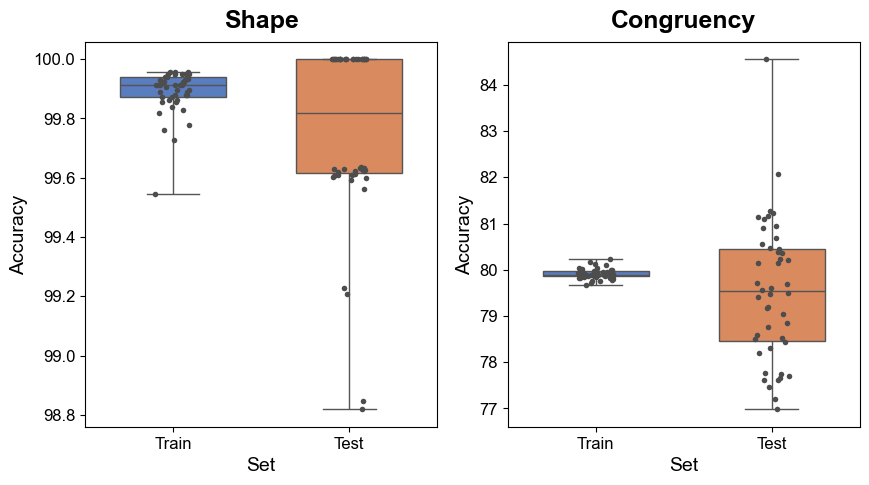

In [211]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family'] = 'Arial'

f, axs = plt.subplots(1, 2, sharex = True,  figsize = [10, 5])
plt.subplot(121)
sns.boxplot(Results[Results.Feature == 'Shape'], x = 'Set', y = 'Accuracy', hue = 'Set',whis=[0, 100], width=.6, palette="muted")
sns.stripplot(Results[Results.Feature == 'Shape'], x = 'Set', y = 'Accuracy', size=4, color=".3")
plt.title('Shape', fontdict=dict(fontsize= 18, font = 'Arial', fontweight='bold'), pad = 10)
plt.xlabel('Set', fontdict=dict(fontsize= 14, font = 'Arial'))
plt.ylabel('Accuracy', fontdict=dict(fontsize= 14, font = 'Arial'))

plt.subplot(122)
sns.boxplot(Results[Results.Feature == 'Congruency'], x = 'Set', y = 'Accuracy', hue = 'Set',whis=[0, 100], width=.6, palette="muted")
sns.stripplot(Results[Results.Feature == 'Congruency'], x = 'Set', y = 'Accuracy', size=4, color=".3")
plt.title('Congruency', fontdict=dict(fontsize= 18, font = 'Arial', fontweight='bold'), pad = 10)
plt.xlabel('Set', fontdict=dict(fontsize= 14, font = 'Arial'))
plt.ylabel('Accuracy', fontdict=dict(fontsize= 14, font = 'Arial'))

Text(0, 0.5, 'Accuracy')

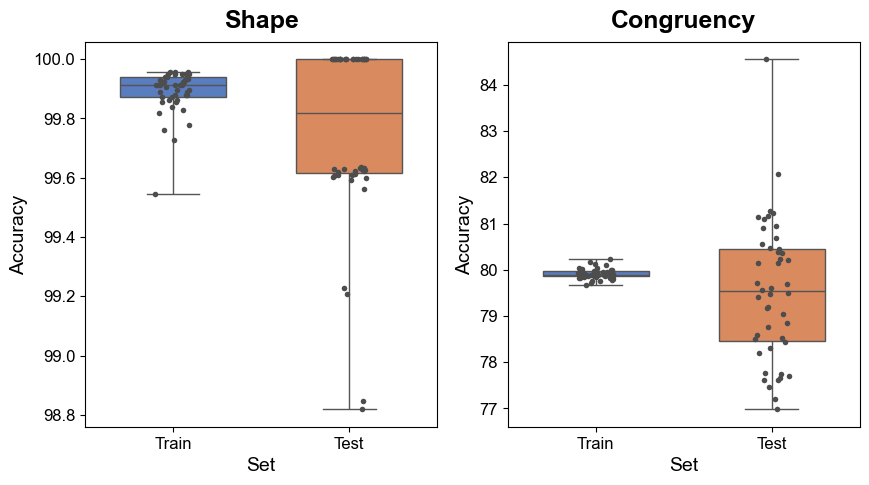

In [211]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family'] = 'Arial'

f, axs = plt.subplots(1, 2, sharex = True,  figsize = [10, 5])
plt.subplot(121)
sns.boxplot(Results[Results.Feature == 'Shape'], x = 'Set', y = 'Accuracy', hue = 'Set',whis=[0, 100], width=.6, palette="muted")
sns.stripplot(Results[Results.Feature == 'Shape'], x = 'Set', y = 'Accuracy', size=4, color=".3")
plt.title('Shape', fontdict=dict(fontsize= 18, font = 'Arial', fontweight='bold'), pad = 10)
plt.xlabel('Set', fontdict=dict(fontsize= 14, font = 'Arial'))
plt.ylabel('Accuracy', fontdict=dict(fontsize= 14, font = 'Arial'))

plt.subplot(122)
sns.boxplot(Results[Results.Feature == 'Congruency'], x = 'Set', y = 'Accuracy', hue = 'Set',whis=[0, 100], width=.6, palette="muted")
sns.stripplot(Results[Results.Feature == 'Congruency'], x = 'Set', y = 'Accuracy', size=4, color=".3")
plt.title('Congruency', fontdict=dict(fontsize= 18, font = 'Arial', fontweight='bold'), pad = 10)
plt.xlabel('Set', fontdict=dict(fontsize= 14, font = 'Arial'))
plt.ylabel('Accuracy', fontdict=dict(fontsize= 14, font = 'Arial'))